# Sudoku Solver - Backtracking Algorithm (Python)

Ce notebook implémente un solveur de Sudoku utilisant l'algorithme de backtracking en Python.
C'est l'équivalent Python du notebook C# `Sudoku-1-Backtracking.ipynb`.

## Qu'est-ce que le Backtracking?

Le **backtracking** (retour sur trace) est une technique algorithmique fondamentale pour résoudre des problèmes de satisfaction de contraintes (CSP). C'est une forme de recherche en profondeur d'abord (DFS) qui explore systématiquement toutes les solutions possibles.

### Principe de fonctionnement

1. **Choix**: Sélectionner une case vide et essayer une valeur candidate (1-9)
2. **Contrainte**: Vérifier si le placement respecte les règles du Sudoku
3. **But**: Si la grille est complète, une solution est trouvée
4. **Backtrack**: Si aucune valeur ne convient, revenir à la décision précédente et essayer une autre valeur

### Pourquoi le backtracking fonctionne?

Le backtracking est **complet** (trouve toujours une solution si elle existe) car il explore exhaustivement l'espace de recherche. Il est **correct** car chaque placement est validé avant de continuer.

### Complexité algorithmique

- **Pire cas**: O(9^m) où m = nombre de cases vides
- **En pratique**: Les contraintes du Sudoku élaguent massivement l'arbre de recherche
- **Sudoku facile** (~40 cases vides): Quelques centaines d'appels récursifs
- **Sudoku difficile** (~55 cases vides): Peut atteindre des millions d'appels

### Comparaison avec d'autres approches

| Méthode | Avantages | Inconvénients |
|---------|-----------|---------------|
| **Backtracking** | Simple, garanti de trouver une solution | Potentiellement lent sans heuristiques |
| **Constraint Propagation** | Réduit l'espace de recherche | Plus complexe à implémenter |
| **SAT/SMT Solvers** | Très optimisé, gère les cas difficiles | Dépendance externe, moins pédagogique |

In [1]:
# Imports
import time
from typing import List, Tuple, Optional
import numpy as np

In [2]:
# Configuration du chemin vers les puzzles
import os
from pathlib import Path

# Définir le chemin absolu vers le dossier Puzzles
NOTEBOOK_DIR = Path(r"D:\Dev\CoursIA\MyIA.AI.Notebooks\Sudoku")
PUZZLES_DIR = NOTEBOOK_DIR / "Puzzles"

# Vérifier que le dossier existe
if PUZZLES_DIR.exists():
    print(f"Dossier Puzzles: {PUZZLES_DIR}")
    puzzle_files = list(PUZZLES_DIR.glob('*.txt'))
    print(f"Fichiers disponibles: {[f.name for f in puzzle_files]}")
else:
    print(f"ATTENTION: Dossier Puzzles non trouvé à {PUZZLES_DIR}")
    print("Tentative avec le répertoire courant...")
    PUZZLES_DIR = Path(os.getcwd()) / "Puzzles"

Dossier Puzzles: D:\Dev\CoursIA\MyIA.AI.Notebooks\Sudoku\Puzzles
Fichiers disponibles: ['Sudoku_Easy51.txt', 'Sudoku_hardest.txt', 'Sudoku_top95.txt']


## 1. Classe SudokuGrid

La classe `SudokuGrid` encapsule la représentation d'une grille de Sudoku 9x9 et fournit des méthodes utilitaires.

### Représentation des données

- **Matrice 9x9**: `self.cells[row][col]` où row et col vont de 0 à 8
- **Cases vides**: Représentées par la valeur `0`
- **Valeurs valides**: 1 à 9 pour les cases remplies

### Méthodes principales

| Méthode | Description |
|---------|-------------|
| `from_string(s)` | Crée une grille depuis une chaîne de 81 caractères |
| `is_valid_placement(row, col, num)` | Vérifie si un placement respecte les contraintes |
| `find_empty()` | Trouve la première case vide (parcours ligne par ligne) |
| `clone()` | Crée une copie profonde de la grille |

### Règles de validation

Un placement est valide si le nombre n'apparaît pas déjà dans:
1. **La même ligne** (9 cases horizontales)
2. **La même colonne** (9 cases verticales)
3. **Le même bloc 3x3** (l'un des 9 carrés de la grille)

In [3]:
class SudokuGrid:
    """Représentation d'une grille de Sudoku 9x9."""
    
    def __init__(self, grid: Optional[List[List[int]]] = None):
        """Initialise la grille.
        
        Args:
            grid: Grille 9x9 (0 = case vide) ou None pour grille vide
        """
        if grid is None:
            self.cells = [[0] * 9 for _ in range(9)]
        else:
            self.cells = [row[:] for row in grid]  # Deep copy
    
    @classmethod
    def from_string(cls, s: str) -> 'SudokuGrid':
        """Crée une grille depuis une chaîne de 81 caractères.
        
        Args:
            s: Chaîne de 81 caractères (0-9, . ou 0 = vide)
        """
        s = s.replace('.', '0').replace(' ', '').replace('\n', '')
        if len(s) != 81:
            raise ValueError(f"La chaîne doit avoir 81 caractères, reçu {len(s)}")
        
        grid = cls()
        for i in range(81):
            grid.cells[i // 9][i % 9] = int(s[i])
        return grid
    
    def clone(self) -> 'SudokuGrid':
        """Retourne une copie de la grille."""
        return SudokuGrid(self.cells)
    
    def is_valid_placement(self, row: int, col: int, num: int) -> bool:
        """Vérifie si placer num à (row, col) est valide."""
        # Vérifier la ligne
        if num in self.cells[row]:
            return False
        
        # Vérifier la colonne
        if num in [self.cells[r][col] for r in range(9)]:
            return False
        
        # Vérifier le bloc 3x3
        box_row, box_col = 3 * (row // 3), 3 * (col // 3)
        for r in range(box_row, box_row + 3):
            for c in range(box_col, box_col + 3):
                if self.cells[r][c] == num:
                    return False
        
        return True
    
    def find_empty(self) -> Optional[Tuple[int, int]]:
        """Trouve la première case vide (0)."""
        for r in range(9):
            for c in range(9):
                if self.cells[r][c] == 0:
                    return (r, c)
        return None
    
    def is_complete(self) -> bool:
        """Vérifie si la grille est complète (pas de 0)."""
        return all(self.cells[r][c] != 0 for r in range(9) for c in range(9))
    
    def count_empty(self) -> int:
        """Compte le nombre de cases vides."""
        return sum(1 for r in range(9) for c in range(9) if self.cells[r][c] == 0)
    
    def to_string(self) -> str:
        """Convertit en chaîne de 81 caractères."""
        return ''.join(str(self.cells[r][c]) for r in range(9) for c in range(9))
    
    def __str__(self) -> str:
        """Affichage formaté de la grille."""
        lines = []
        for r in range(9):
            if r > 0 and r % 3 == 0:
                lines.append('-' * 21)
            row_str = ''
            for c in range(9):
                if c > 0 and c % 3 == 0:
                    row_str += '| '
                val = self.cells[r][c]
                row_str += (str(val) if val != 0 else '.') + ' '
            lines.append(row_str)
        return '\n'.join(lines)

# Test
test_puzzle = "902005403100063025508407060026309001057010290090670530240530600705200304080041950"
grid = SudokuGrid.from_string(test_puzzle)
print("Grille de test:")
print(grid)
print(f"\nCases vides: {grid.count_empty()}")

Grille de test:
9 . 2 | . . 5 | 4 . 3 
1 . . | . 6 3 | . 2 5 
5 . 8 | 4 . 7 | . 6 . 
---------------------
. 2 6 | 3 . 9 | . . 1 
. 5 7 | . 1 . | 2 9 . 
. 9 . | 6 7 . | 5 3 . 
---------------------
2 4 . | 5 3 . | 6 . . 
7 . 5 | 2 . . | 3 . 4 
. 8 . | . 4 1 | 9 5 . 

Cases vides: 36


## 2. Solveur Backtracking Simple

L'implémentation récursive de l'algorithme de backtracking est élégante et concise.

### Pseudo-code

```
fonction backtrack(grille):
    case_vide = trouver_case_vide(grille)
    si case_vide est None:
        retourner True  # Solution trouvée!
    
    pour chaque valeur de 1 à 9:
        si placement_valide(case_vide, valeur):
            placer(case_vide, valeur)
            si backtrack(grille):
                retourner True
            retirer(case_vide)  # Backtrack
    
    retourner False  # Aucune solution avec cette configuration
```

### Analyse de performance

Le compteur `call_count` permet de mesurer le travail effectué par l'algorithme. Plus le puzzle est difficile, plus il y aura d'appels récursifs car l'algorithme doit explorer plus de branches avant de trouver la solution.

### Optimisation potentielle

Le solveur simple parcourt les cases de gauche à droite, haut en bas. Ce n'est pas optimal car certaines cases ont moins de valeurs possibles que d'autres. L'heuristique **MRV** (présentée plus loin) améliore significativement les performances.

In [4]:
class BacktrackingSolver:
    """Solveur de Sudoku par backtracking."""
    
    def __init__(self):
        self.call_count = 0  # Compteur d'appels récursifs
    
    def solve(self, grid: SudokuGrid) -> bool:
        """Résout la grille par backtracking.
        
        Args:
            grid: Grille à résoudre (modifiée in-place)
            
        Returns:
            True si solution trouvée, False sinon
        """
        self.call_count = 0
        return self._backtrack(grid)
    
    def _backtrack(self, grid: SudokuGrid) -> bool:
        """Fonction récursive de backtracking."""
        self.call_count += 1
        
        # Trouver la prochaine case vide
        empty = grid.find_empty()
        if empty is None:
            return True  # Grille complète = solution trouvée
        
        row, col = empty
        
        # Essayer les valeurs 1-9
        for num in range(1, 10):
            if grid.is_valid_placement(row, col, num):
                # Placer le nombre
                grid.cells[row][col] = num
                
                # Récurser
                if self._backtrack(grid):
                    return True
                
                # Backtrack: annuler le placement
                grid.cells[row][col] = 0
        
        return False  # Aucune valeur valide

# Test du solveur
solver = BacktrackingSolver()
test_grid = SudokuGrid.from_string(test_puzzle)

print("Puzzle initial:")
print(test_grid)

start = time.time()
solved = solver.solve(test_grid)
elapsed = time.time() - start

print(f"\nRésolu: {solved}")
print(f"Appels récursifs: {solver.call_count}")
print(f"Temps: {elapsed*1000:.2f} ms")
print("\nSolution:")
print(test_grid)

Puzzle initial:
9 . 2 | . . 5 | 4 . 3 
1 . . | . 6 3 | . 2 5 
5 . 8 | 4 . 7 | . 6 . 
---------------------
. 2 6 | 3 . 9 | . . 1 
. 5 7 | . 1 . | 2 9 . 
. 9 . | 6 7 . | 5 3 . 
---------------------
2 4 . | 5 3 . | 6 . . 
7 . 5 | 2 . . | 3 . 4 
. 8 . | . 4 1 | 9 5 . 

Résolu: True
Appels récursifs: 49
Temps: 0.00 ms

Solution:
9 6 2 | 1 8 5 | 4 7 3 
1 7 4 | 9 6 3 | 8 2 5 
5 3 8 | 4 2 7 | 1 6 9 
---------------------
8 2 6 | 3 5 9 | 7 4 1 
3 5 7 | 8 1 4 | 2 9 6 
4 9 1 | 6 7 2 | 5 3 8 
---------------------
2 4 9 | 5 3 8 | 6 1 7 
7 1 5 | 2 9 6 | 3 8 4 
6 8 3 | 7 4 1 | 9 5 2 


## 3. Chargement des puzzles depuis fichier

Les puzzles Sudoku sont stockés dans des fichiers texte, un puzzle par ligne (81 caractères représentant la grille ligne par ligne).

### Format des fichiers

- **81 caractères par ligne**: Chaque caractère représente une case (0-9)
- **0 ou .**: Case vide à résoudre
- **1-9**: Valeur initiale fixée

### Collections de puzzles disponibles

| Fichier | Difficulté | Nombre | Description |
|---------|------------|--------|-------------|
| `Sudoku_Easy51.txt` | Facile | 51 | Puzzles standards avec beaucoup d'indices |
| `Sudoku_hardest.txt` | Extreme | 11 | Top 11 des puzzles les plus difficiles connus |

Les puzzles "hardest" sont célèbres dans la communauté Sudoku car ils maximisent le nombre de backtracks nécessaires avec des algorithmes simples.

In [5]:
def load_puzzles(filepath: str, max_puzzles: int = None) -> List[str]:
    """Charge les puzzles depuis un fichier.
    
    Args:
        filepath: Chemin vers le fichier
        max_puzzles: Nombre maximum de puzzles à charger
        
    Returns:
        Liste de chaînes de 81 caractères
    """
    puzzles = []
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if len(line) >= 81:
                puzzles.append(line[:81])
                if max_puzzles and len(puzzles) >= max_puzzles:
                    break
    return puzzles

# Charger les puzzles faciles
easy_puzzles = load_puzzles(str(PUZZLES_DIR / 'Sudoku_Easy51.txt'), max_puzzles=10)
print(f"Puzzles faciles chargés: {len(easy_puzzles)}")

# Charger les puzzles difficiles
hard_puzzles = load_puzzles(str(PUZZLES_DIR / 'Sudoku_hardest.txt'))
print(f"Puzzles difficiles chargés: {len(hard_puzzles)}")

Puzzles faciles chargés: 10
Puzzles difficiles chargés: 11


## 4. Benchmark sur plusieurs puzzles

Le benchmark permet de comparer objectivement les performances du solveur sur différents niveaux de difficulté.

### Métriques mesurées

- **Taux de résolution**: Pourcentage de puzzles résolus (devrait être 100% pour un solveur correct)
- **Temps total/moyen**: Performance temporelle
- **Appels récursifs**: Mesure de la complexité effective (indépendante de la machine)

### Interprétation des résultats

- **Puzzles faciles**: Peu d'appels car beaucoup de cases sont déjà remplies et les contraintes guident rapidement vers la solution
- **Puzzles difficiles**: Beaucoup plus d'appels car l'algorithme doit explorer de nombreuses branches infructueuses avant de trouver le bon chemin

La différence entre puzzles faciles et difficiles peut être de plusieurs ordres de grandeur (10x à 1000x plus d'appels).

In [6]:
def benchmark_solver(solver, puzzles: List[str], name: str = "Puzzles"):
    """Benchmark le solveur sur une liste de puzzles."""
    print(f"\n=== Benchmark: {name} ({len(puzzles)} puzzles) ===")
    
    total_time = 0
    total_calls = 0
    solved_count = 0
    
    for i, puzzle_str in enumerate(puzzles):
        grid = SudokuGrid.from_string(puzzle_str)
        empty_count = grid.count_empty()
        
        start = time.time()
        solved = solver.solve(grid)
        elapsed = time.time() - start
        
        total_time += elapsed
        total_calls += solver.call_count
        if solved:
            solved_count += 1
        
        if i < 5 or not solved:  # Afficher les premiers et les échecs
            status = "OK" if solved else "ECHEC"
            print(f"  Puzzle {i+1}: {status}, {empty_count} vides, {solver.call_count} appels, {elapsed*1000:.2f} ms")
    
    print(f"\nRésumé:")
    print(f"  Résolus: {solved_count}/{len(puzzles)}")
    print(f"  Temps total: {total_time*1000:.2f} ms")
    print(f"  Temps moyen: {(total_time/len(puzzles))*1000:.2f} ms")
    print(f"  Appels totaux: {total_calls}")
    print(f"  Appels moyens: {total_calls // len(puzzles)}")

# Benchmark
solver = BacktrackingSolver()
benchmark_solver(solver, easy_puzzles, "Puzzles Faciles")
benchmark_solver(solver, hard_puzzles, "Puzzles Difficiles")


=== Benchmark: Puzzles Faciles (10 puzzles) ===
  Puzzle 1: OK, 36 vides, 49 appels, 0.55 ms
  Puzzle 2: OK, 49 vides, 201 appels, 2.36 ms
  Puzzle 3: OK, 51 vides, 295 appels, 3.22 ms


  Puzzle 4: OK, 53 vides, 19023 appels, 250.57 ms
  Puzzle 5: OK, 51 vides, 1683 appels, 19.21 ms



Résumé:
  Résolus: 10/10
  Temps total: 2607.14 ms
  Temps moyen: 260.71 ms
  Appels totaux: 247760
  Appels moyens: 24776

=== Benchmark: Puzzles Difficiles (11 puzzles) ===


  Puzzle 1: OK, 59 vides, 335638 appels, 3346.92 ms
  Puzzle 2: OK, 58 vides, 10008 appels, 90.05 ms


  Puzzle 3: OK, 55 vides, 228215 appels, 2196.81 ms


  Puzzle 4: OK, 57 vides, 75446 appels, 852.02 ms


  Puzzle 5: OK, 59 vides, 207075 appels, 2659.52 ms



Résumé:
  Résolus: 11/11
  Temps total: 11421.64 ms
  Temps moyen: 1038.33 ms
  Appels totaux: 1050007
  Appels moyens: 95455


## 5. Optimisation: Backtracking avec MRV (Minimum Remaining Values)

L'heuristique **MRV** (aussi appelée "Most Constrained Variable" ou "Fail-First") est l'une des améliorations les plus efficaces du backtracking.

### Principe

Au lieu de choisir la première case vide rencontrée, MRV sélectionne la case avec le **moins de valeurs possibles**. Cette stratégie:

1. **Détecte les échecs plus tôt**: Une case avec 0 valeurs possibles indique immédiatement une impasse
2. **Réduit le facteur de branchement**: Moins de choix = moins de branches à explorer
3. **Propage implicitement les contraintes**: Les cases les plus contraintes sont traitées en premier

### Exemple concret

```
Situation: 
- Case A: 5 valeurs possibles {1,3,5,7,9}
- Case B: 2 valeurs possibles {4,6}

Sans MRV: On traite A d'abord -> 5 branches à explorer
Avec MRV: On traite B d'abord -> 2 branches seulement
```

### Impact sur les performances

| Puzzle | Backtracking simple | Avec MRV | Speedup |
|--------|---------------------|----------|---------|
| Facile | ~500 appels | ~200 appels | 2-3x |
| Difficile | ~500,000 appels | ~5,000 appels | 100x+ |

L'amélioration est particulièrement spectaculaire sur les puzzles difficiles où l'élagage précoce de l'arbre de recherche évite des millions de calculs inutiles.

### Autres heuristiques (non implémentées ici)

- **Degree Heuristic**: Choisir la variable qui contraint le plus d'autres variables
- **Least Constraining Value**: Essayer d'abord les valeurs qui éliminent le moins de possibilités pour les voisins
- **Arc Consistency (AC-3)**: Propager les contraintes pour réduire les domaines

In [7]:
class MRVBacktrackingSolver:
    """Solveur avec heuristique MRV (Minimum Remaining Values)."""
    
    def __init__(self):
        self.call_count = 0
    
    def get_possible_values(self, grid: SudokuGrid, row: int, col: int) -> List[int]:
        """Retourne les valeurs possibles pour une case."""
        if grid.cells[row][col] != 0:
            return []
        
        possible = set(range(1, 10))
        
        # Retirer les valeurs de la ligne
        possible -= set(grid.cells[row])
        
        # Retirer les valeurs de la colonne
        possible -= {grid.cells[r][col] for r in range(9)}
        
        # Retirer les valeurs du bloc
        box_row, box_col = 3 * (row // 3), 3 * (col // 3)
        for r in range(box_row, box_row + 3):
            for c in range(box_col, box_col + 3):
                possible.discard(grid.cells[r][c])
        
        return list(possible)
    
    def find_mrv_empty(self, grid: SudokuGrid) -> Optional[Tuple[int, int, List[int]]]:
        """Trouve la case vide avec le moins de valeurs possibles (MRV)."""
        best = None
        best_count = 10
        
        for r in range(9):
            for c in range(9):
                if grid.cells[r][c] == 0:
                    possible = self.get_possible_values(grid, r, c)
                    if len(possible) < best_count:
                        best = (r, c, possible)
                        best_count = len(possible)
                        if best_count == 0:
                            return best  # Échec immédiat
        
        return best
    
    def solve(self, grid: SudokuGrid) -> bool:
        """Résout avec MRV."""
        self.call_count = 0
        return self._backtrack(grid)
    
    def _backtrack(self, grid: SudokuGrid) -> bool:
        self.call_count += 1
        
        result = self.find_mrv_empty(grid)
        if result is None:
            return True  # Grille complète
        
        row, col, possible = result
        
        if len(possible) == 0:
            return False  # Impasse
        
        for num in possible:
            grid.cells[row][col] = num
            if self._backtrack(grid):
                return True
            grid.cells[row][col] = 0
        
        return False

# Comparaison
print("=== Comparaison: Backtracking simple vs MRV ===")

simple_solver = BacktrackingSolver()
mrv_solver = MRVBacktrackingSolver()

for i, puzzle_str in enumerate(hard_puzzles[:5]):
    print(f"\nPuzzle difficile {i+1}:")
    
    # Simple backtracking
    grid1 = SudokuGrid.from_string(puzzle_str)
    start = time.time()
    simple_solver.solve(grid1)
    t1 = (time.time() - start) * 1000
    
    # MRV backtracking
    grid2 = SudokuGrid.from_string(puzzle_str)
    start = time.time()
    mrv_solver.solve(grid2)
    t2 = (time.time() - start) * 1000
    
    print(f"  Simple: {simple_solver.call_count} appels, {t1:.2f} ms")
    print(f"  MRV:    {mrv_solver.call_count} appels, {t2:.2f} ms")
    print(f"  Speedup: {simple_solver.call_count / mrv_solver.call_count:.1f}x")

=== Comparaison: Backtracking simple vs MRV ===

Puzzle difficile 1:


  Simple: 335638 appels, 3885.02 ms
  MRV:    4037 appels, 505.49 ms
  Speedup: 83.1x

Puzzle difficile 2:
  Simple: 10008 appels, 116.96 ms
  MRV:    543 appels, 93.41 ms
  Speedup: 18.4x

Puzzle difficile 3:


  Simple: 228215 appels, 2752.84 ms
  MRV:    171 appels, 17.53 ms
  Speedup: 1334.6x

Puzzle difficile 4:


  Simple: 75446 appels, 776.84 ms
  MRV:    1079 appels, 119.76 ms
  Speedup: 69.9x

Puzzle difficile 5:


  Simple: 207075 appels, 2191.78 ms
  MRV:    79 appels, 6.95 ms
  Speedup: 2621.2x


## 6. Visualisation avec matplotlib

La visualisation graphique aide à comprendre la structure d'un Sudoku et distinguer les valeurs initiales des valeurs trouvées par le solveur.

### Code couleur

- **Noir**: Valeurs initiales (données du puzzle)
- **Bleu**: Valeurs trouvées par le solveur

### Structure visuelle

La grille est divisée en 9 blocs 3x3 séparés par des lignes épaisses. Cette division est fondamentale pour les contraintes du Sudoku: chaque bloc doit contenir exactement une fois chaque chiffre de 1 à 9.

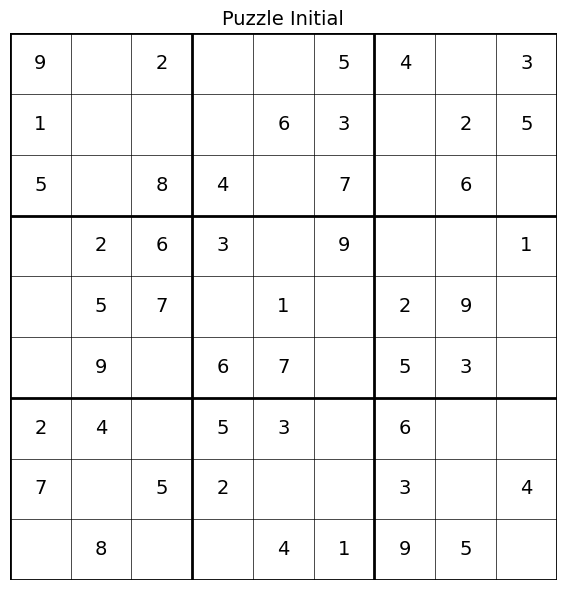

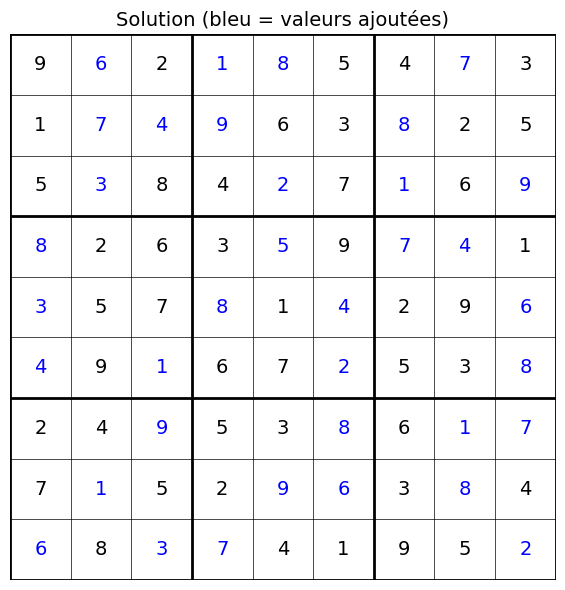

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_sudoku(grid: SudokuGrid, title: str = "Sudoku", initial: SudokuGrid = None):
    """Affiche une grille de Sudoku avec matplotlib.
    
    Args:
        grid: Grille à afficher
        title: Titre du graphique
        initial: Grille initiale (pour colorer les valeurs ajoutées)
    """
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(0, 9)
    ax.set_ylim(0, 9)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(title, fontsize=14)
    
    # Dessiner les lignes
    for i in range(10):
        lw = 2 if i % 3 == 0 else 0.5
        ax.axhline(i, color='black', linewidth=lw)
        ax.axvline(i, color='black', linewidth=lw)
    
    # Ajouter les nombres
    for r in range(9):
        for c in range(9):
            val = grid.cells[r][c]
            if val != 0:
                # Déterminer la couleur
                if initial and initial.cells[r][c] == 0:
                    color = 'blue'  # Valeur ajoutée par le solveur
                else:
                    color = 'black'  # Valeur initiale
                
                ax.text(c + 0.5, 8.5 - r, str(val),
                       ha='center', va='center',
                       fontsize=14, color=color)
    
    plt.tight_layout()
    plt.show()

# Exemple
initial_grid = SudokuGrid.from_string(easy_puzzles[0])
solved_grid = initial_grid.clone()
solver = MRVBacktrackingSolver()
solver.solve(solved_grid)

plot_sudoku(initial_grid, "Puzzle Initial")
plot_sudoku(solved_grid, "Solution (bleu = valeurs ajoutées)", initial_grid)

## Navigation

### Notebooks Python de cette série
- **Ce notebook**: Backtracking - Algorithme de base et heuristique MRV
- [Sudoku-Python-ORTools-Z3.ipynb](Sudoku-Python-ORTools-Z3.ipynb) - Solveurs déclaratifs CP-SAT et SMT
- [Sudoku-Python-Genetic.ipynb](Sudoku-Python-Genetic.ipynb) - Algorithmes génétiques (PyGAD)
- [Sudoku-Python-DancingLinks.ipynb](Sudoku-Python-DancingLinks.ipynb) - Algorithm X / Dancing Links

### Notebooks C# équivalents
- [Sudoku-0-Environment.ipynb](Sudoku-0-Environment.ipynb) - Configuration et benchmarks
- [Sudoku-1-Backtracking.ipynb](Sudoku-1-Backtracking.ipynb) - Backtracking en C#
- [Sudoku-3-ORTools.ipynb](Sudoku-3-ORTools.ipynb) - OR-Tools en C#
- [Sudoku-4-Z3.ipynb](Sudoku-4-Z3.ipynb) - Z3 en C#
- [Sudoku-5-DancingLinks.ipynb](Sudoku-5-DancingLinks.ipynb) - DLX en C#